In [1]:
import rasterio
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import rasterio
import rasterio.mask
import numpy as np
import numpy.ma as ma
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import os
import shutil
from zipfile import ZipFile
from pprint import pprint as pp
from matplotlib import pyplot
import pandas as pd

USER = 'bigusdeveloper'
PW = 'ZFknqZ3^44&&VGek'

In [2]:
api = SentinelAPI(USER, PW, api_url='https://scihub.copernicus.eu/dhus')

In [3]:
farm_geometries = read_geojson('../KMZs/votm/Farm_boundary.geojson')
footprint = geojson_to_wkt(farm_geometries)

In [4]:
products = api.query(footprint,
                     area_relation='Contains',
                     date=('20190401', '20191031'),
                     platformname='Sentinel-2',
                     processinglevel='Level-2A')

#pp(products)

In [5]:
product_gdf = api.to_geodataframe(products)

/Users/MarkNyberg/PycharmProjects/sentinel_processing/venv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
product_gdf['ingestiondate'] = pd.to_datetime(product_gdf['ingestiondate'], format='%Y-%m-%d %H:%M:%S.%f')

In [21]:
date_cloud = product_gdf[['ingestiondate', 'cloudcoverpercentage']]

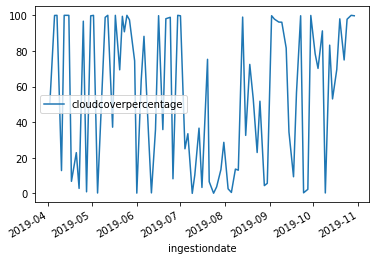

In [29]:
date_cloud.plot(x='ingestiondate', y='cloudcoverpercentage', kind='line')

In [ ]:
products_gdf_sorted = products_gdf.sort_values(['ingestiondate'], ascending=[False])
products_gdf_sorted = products_gdf_sorted.head(1)

In [ ]:
api.download_all(products, directory_path='./data/')

In [14]:
with ZipFile('./S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.zip', 'r') as zipObj:
    zipObj.extractall('temp')

In [7]:
with ZipFile('./downloads/S2B_MSIL2A_20200420T163829_N0214_R126_T16TCM_20200420T210016.zip', 'r') as zipObj:
    zipObj.extractall('./data/')

In [10]:
os.remove('./downloads/S2B_MSIL2A_20200420T163829_N0214_R126_T16TCM_20200420T210016.zip')

In [8]:
grazing_mask = gpd.read_file('grazing.json')

print(grazing_mask.crs)

with rasterio.open('./data/S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.SAFE/GRANULE/L2A_T16TCM_A025191_20200418T165421/IMG_DATA/R10m/T16TCM_20200418T164901_B04_10m.jp2') as src:
    print(src.crs)


epsg:4326
EPSG:32616


In [5]:
dst_crs = 'EPSG:4326'

with rasterio.open('./data/S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.SAFE/GRANULE/L2A_T16TCM_A025191_20200418T165421/IMG_DATA/R10m/T16TCM_20200418T164901_B04_10m.jp2') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs,
                                                           src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})

    with rasterio.open('./output1.tiff', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [7]:
info_test = rasterio.open('./output.tiff', 'r')

print(info_test.crs)
print(info_test.dtypes)

info_test.close()

EPSG:4326
('uint16',)


/Users/MarkNyberg/PycharmProjects/sentinel_processing/venv/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
with rasterio.open('output1.tiff', 'r') as src:
    out_image, out_transform = rasterio.mask.mask(src,
                                                  grazing_mask.geometry,
                                                  crop=True)
    out_meta = src.meta.copy()
    out_meta.update({'height': out_image.shape[1],
                     'width': out_image.shape[2],
                     'transform': out_transform})
    with rasterio.open('./masked_tiff.tiff', 'w', **out_meta) as dest:
        dest.write(out_image)


In [2]:
base_path = './S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.SAFE/GRANULE/L2A_T16TCM_A025191_20200418T165421/IMG_DATA/R10m/'
b4 = rasterio.open(base_path + 'T16TCM_20200418T164901_B04_10m.jp2')
b3 = rasterio.open(base_path + 'T16TCM_20200418T164901_B03_10m.jp2')
b2 = rasterio.open(base_path + 'T16TCM_20200418T164901_B02_10m.jp2')

print(b4.crs)

with rasterio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height,
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1)
    rgb.write(b3.read(1),2)
    rgb.write(b4.read(1),3)
    rgb.close()

EPSG:32616


In [3]:
grazing_mask = gpd.read_file('grazing.json')
transform_grazing = grazing_mask.to_crs('epsg:32616')

with rasterio.open('RGB.tiff') as src:
    out_image, out_transform = rasterio.mask.mask(src, transform_grazing.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                     'height': out_image.shape[1],
                     'width': out_image.shape[2],
                     'transform': out_transform})

with rasterio.open('RGB_masked.tiff', 'w', **out_meta) as dest:
    dest.write(out_image)

In [26]:
b4 = rasterio.open('./data/S2B_MSIL2A_20200420T163829_N0214_R126_T16TCM_20200420T210016.SAFE/GRANULE/L2A_T16TCM_A016311_20200420T165055/IMG_DATA/R10m/T16TCM_20200420T163829_B04_10m.jp2')
b8 = rasterio.open('./data/S2B_MSIL2A_20200420T163829_N0214_R126_T16TCM_20200420T210016.SAFE/GRANULE/L2A_T16TCM_A016311_20200420T165055/IMG_DATA/R10m/T16TCM_20200420T163829_B08_10m.jp2')

red = b4.read()
nir = b8.read()

ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI2.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))


/Users/MarkNyberg/PycharmProjects/sentinel_processing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [27]:
grazing_mask = gpd.read_file('grazing.json')
transform_grazing = grazing_mask.to_crs('epsg:32616')

with rasterio.open('NDVI2.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, transform_grazing.geometry, crop=True, nodata=-1)
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                     'height': out_image.shape[1],
                     'width': out_image.shape[2],
                     'transform': out_transform})

with rasterio.open('NDVI2_masked.tiff', 'w', **out_meta) as dest:
    dest.write(out_image)

In [5]:
# working on accessing array data from masked tif to do analysis
with rasterio.open('NDVI2_masked.tiff', 'r') as experiment:
    data = experiment.read(1)
    masked_data = ma.masked_less_equal(data, -1)
    print(f'Mean - {masked_data.mean()}')
    print(f'Max - {masked_data.max()}')
    print(f'Min - {masked_data.min()}')
    print(f'Cells - {masked_data.count()}')
    print(f'25th Percentile - {np.nanpercentile(masked_data, 60)}')
    print(f'Std - {masked_data.std()}')
    print(f'Var - {masked_data.var()}')

Mean - 0.3978427959056594
Max - 0.862468957901001
Min - 0.0952494665980339
Cells - 2434
25th Percentile - 0.16954222023487092
Std - 0.20301366518351482
Var - 0.04121454825124426


In [7]:
with rasterio.open('NDVI_masked.tiff', 'r') as experiment:
    data = experiment.read(1)
    masked_data = ma.masked_less_equal(data, -1)
    print(f'Mean - {masked_data.mean()}')
    print(f'Max - {masked_data.max()}')
    print(f'Min - {masked_data.min()}')
    print(f'Cells - {masked_data.count()}')
    print(f'60th Percentile - {np.nanpercentile(masked_data, 50)}')
    print(f'Std - {masked_data.std()}')
    print(f'Var - {masked_data.var()}')

Mean - 0.6520767901506008
Max - 0.9172413945198059
Min - 0.14407140016555786
Cells - 2434
60th Percentile - -1.0
Std - 0.11948863006525473
Var - 0.014277532714871298


In [28]:
df = gpd.read_file('farm_simple.geojson')
df[df.name == 'Farm boundary'] # retrieves a single element from GeoDataFrame

,name,geometry
0,Farm boundary,"POLYGON Z ((-89.14164 42.17151 0.00000, -89.14..."


In [50]:
localname = './data/S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.SAFE/GRANULE/L2A_T16TCM_A025191_20200418T165421/IMG_DATA/R10m/T16TCM_20200418T164901_B08_10m.jp2'
tifname = 'WGS84-reproject.tif'

dst_crs = 'EPSG:4326'

with rasterio.open(localname) as src:
    transform, width, height = rasterio.warp.calculate_default_transform(src.crs,
                                                                         dst_crs,
                                                                         10980,
                                                                         10980,
                                                                         left=src.bounds.left,
                                                                         right=src.bounds.right,
                                                                         top=src.bounds.top,
                                                                         bottom=src.bounds.bottom)

    with rasterio.open(tifname, 'w', driver='GTiff',
                       height=10980, width=10980,
                       count=1, transform=transform,
                       crs=dst_crs, dtype=rasterio.uint16) as dst:
        destination, dest_transform = rasterio.warp.reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1))
        dst.write(destination)

AttributeError: 'Profile' object has no attribute 'dtype'

In [41]:
localname = './data/S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.SAFE/GRANULE/L2A_T16TCM_A025191_20200418T165421/IMG_DATA/R10m/T16TCM_20200418T164901_B08_10m.jp2'
tifname = 'WGS84-reproject.tif'

dst_crs = 'EPSG:4326'

with rasterio.open(localname) as src:
    print(src.height)
    print(src.width)
    print(src.bounds.left)
    print(src.bounds.right)

10980
10980
300000.0
409800.0
